## I-3 Gaussian Mixture Models of Trip Durations
In the previous part, the Hypothesis Testing was performed to distinguish between Casual and<br />
Registered users of the bike sharing service. Moving forwards, we would like to understand
the <br />distribution of trip durations so that we can better choose the scooter the startup will
use.<br /><br/> 

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
from scipy.stats import norm
import scipy.stats
from sklearn import mixture
%matplotlib inline

### 3.1 Exploration
Let's assume that the main factor infuencing the length of the trip is whether or not a
customer<br /> is a subscriber.The following charts and analysis explains why it's reasonable to believe that <br />should be a difference in the distributions
of trip durations of subscribers and non-subscribed <br />customers.

In [118]:
# Read in the csv of chicago.
chi_df = pd.read_csv("../data/bikeshare/chicago.csv")

# Save all trip durations in a numpy array.
all_trip_dur = chi_df[chi_df["tripduration"] < 3600]["tripduration"]/60  #.to_numpy()

# Split the tripduration by usertype.
is_subc = (chi_df["usertype"] == "Subscriber")
subc_dur = all_trip_dur[is_subc]
cas_dur = all_trip_dur[is_subc == False]

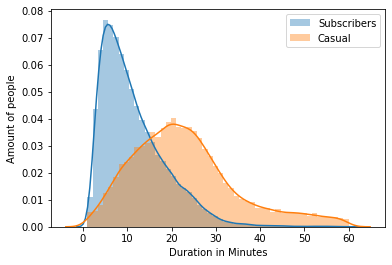

In [119]:
# Plot a histogram of Subscribers and casual riders' trip durations.
sns.distplot(subc_dur, kde=True, label = "Subscribers")
sns.distplot(cas_dur, kde=True, label = "Casual")
plt.xlabel("Duration in Minutes")
plt.ylabel("Amount of people")
plt.legend()
plt.show()

In [120]:
# Find the mean of subscriber trip durations and the standard deviation of subscriber trip durations.
mu_subc = statistics.mean(subc_dur)
sigma_subc = statistics.stdev(subc_dur)

# Find the mean of casual trip durations and the standard deviation of casual trip durations.
mu_cas = statistics.mean(cas_dur)
sigma_cas = statistics.stdev(cas_dur)  

# Find the number of subscribers and casuals.
num_subc = subc_dur.shape[0]
num_cas = cas_dur.shape[0]
num_people = all_trip_dur.shape[0]
pi_subc = num_subc/(num_people)     
pi_cas = num_cas/num_people     

# Print all the statistics.
print("---Subscriber Statistics---")
print("pi_subc ={:.4f}, mu_subc = {:.2f}, sigma_subc = {:.2f}".format(pi_subc, mu_subc, sigma_subc))
print("---Casual Rider Statistics---")
print("pi_cas ={:.4f}, mu_subc = {:.2f}, sigma_cas = {:.2f}".format(pi_cas, mu_cas, sigma_cas))

---Subscriber Statistics---
pi_subc =0.7763, mu_subc = 11.40, sigma_subc = 7.26
---Casual Rider Statistics---
pi_cas =0.2237, mu_subc = 22.89, sigma_cas = 11.79


**Interpretation:**   As described by both graph and summary statistics, there's pretty evidence that the two types <br />of user distributed differently(as two right_skew normal distribution), and it's reasonable to run a mix Gaussian<br /> model on this dataset.

### 3.2 Expectation-Maximization (E-M) Algorithm to learn a mixture of two Gaussians
We focus on the distribution trip-durations of length **less than one hour** in
the chicago.csv dataset.<br /> The algorithm is ran multiple times with different initializations

In [121]:
# Find the mean and the standard deviation of trip durations.
mu_a = statistics.mean(all_trip_dur)
sigma_a = statistics.stdev(all_trip_dur)

# Print the statistics across all trip durations.
print("---All Statistics---")
print("mu_a = {:.2f}, sigma_a={:.2f}".format(mu_a, sigma_a))

---All Statistics---
mu_a = 13.97, sigma_a=9.74


* For comparison purposes, I also generate a similation without Mix-Gaussian. Now I plotted the histogram  <br /> of all heights and compare it to a histogram of data that has actually been generated from the distribution $\mathcal{N}(\mu_a, \sigma_a)$.

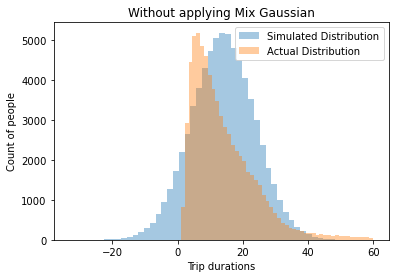

In [122]:
# Create random_state so any random operation always returns the same result.
random_state = np.random.RandomState(0)

# Generate some normally distributed random data with
# mean mu_a and standard deviation sigma_a.
num_people = all_trip_dur.shape[0]
generated_trip_dur = random_state.randn(num_people) * sigma_a + mu_a

# Plot the generated data.
sns.distplot(generated_trip_dur, kde=False, label="Simulated Distribution")
# Plot the real trip durations.
sns.distplot(all_trip_dur, kde=False, label="Actual Distribution")
# Add the legend and axis labels to the plot.
plt.xlabel("Trip durations")
plt.ylabel("Count of people")
plt.title("Without applying Mix Gaussian")
plt.legend()
plt.show()

* Now, let's officially leverage Mix-Gaussian

In [123]:
def gmm_expectation_maximization(data, pi_0, mu_0, pi_1, mu_1, num_steps):
    """ Perform expectation maximization assuming a Gaussian mixture model consisting of two Gaussians.
    
    Parameters
    ----------
    data : numpy array of shape n
        The matrix of datapoints we've observed.
    pi_0 : float
        Our initial estimate of pi_0.
    mu_0 : float
        Our initial estimate of mu_0.
    pi_1 : float
        Our initial estimate of pi_1.
    mu_1 : float
        Our initial estimate of mu_1.
    num_steps : int
        The number of times to run the expectation maximization.
    """
    for step in range(num_steps):
        # First run the expectation step.
        gaussian_prob_0 = (np.exp(-(data - mu_0) ** 2 / (2 * sigma_0)) /
                           (np.sqrt(2 * np.pi) * sigma_0))
        gaussian_prob_1 = (np.exp(-(data - mu_1) ** 2 / (2 * sigma_1)) /
                           (np.sqrt(2 * np.pi) * sigma_1))
        normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1
        # z_k is the vector of estimated probabilities that each datapoint i
        # belongs to the distribution k. In other words the ith index is an
        # estimate of P(K=k|x_i).
        z_0 = pi_0 * gaussian_prob_0 / normalizing_factor
        z_1 = pi_1 * gaussian_prob_1 / normalizing_factor
        
        # Now run the maximization step.
        # N_k is the estimated number of points assigned to the distribution k.
        N_0 = np.sum(z_0)
        N_1 = np.sum(z_1)
        pi_0 = N_0 / data.shape[0]
        pi_1 = N_1 / data.shape[0]
        mu_0 = np.sum(z_0*data)/np.sum(z_0)     
        mu_1 = np.sum(z_1*data)/np.sum(z_1)
        
    return pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1

**Note:** I tried a few initializations for the E-M algorithm, the results are changing pretty drastically, depending <br />on the initial means and standard deviations I chose. After a few testing, I found my "initial guess 1" works the best <br />with the E-M algothm. Therefore, I sticked to the "initial guess 1", and took the posterior of "initial guess 1" as <br />my fitted Gaussians for the next part.  

The fitted Gaussian statistics,   

subscribers: $\hat\pi_{0} = 0.6970,   \hat\mu_{0} = 8.82,   \hat\sigma_{subc} = 7.26$   

casual riders: $\hat\pi_{1} = 0.3030, \hat\mu_{1} = 25.83, \hat\sigma_{cas}= 11.79$

* below, I will show how to get the results above

#### -------initial guess 1--------
$\pi_{0}= 0.5$,    $\mu_{0}= 10$,   $\sigma_{0} = 7.26$  
$\pi_{1} = 0.5$,   $\mu_{1}= 18$,   $\sigma_{1} = 11.79$ 

In [124]:
# compute
sigma_0 = 7.26
sigma_1 = 11.79
# Fill in the parameters below with the values specified in the above cell.
pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data = all_trip_dur,
                                                                        pi_0= 0.5,
                                                                        mu_0= 10,
                                                                        pi_1= 0.5,
                                                                        mu_1= 18,
                                                                        num_steps=100)
# Print the estimated parameters for both distributions.
print("---Distribution 0 Estimated Parameters---")
print("pi_0 = {:.4f}, mu_0 = {:.2f}, sigma_subc = {:.2f}".format(pi_0, mu_0, sigma_subc))
print("---Distribution 1 Estimated Parameters---")
print("pi_1 = {:.4f}, mu_1 = {:.2f}, sigma_cas = {:.2f}".format(pi_1, mu_1, sigma_cas))

---Distribution 0 Estimated Parameters---
pi_0 = 0.6970, mu_0 = 8.82, sigma_subc = 7.26
---Distribution 1 Estimated Parameters---
pi_1 = 0.3030, mu_1 = 25.83, sigma_cas = 11.79


#### -------initial guess 2--------
$\pi_{0}= 0.5$,   $\mu_{0}= 10$,   $\sigma_{0} = 10$    
$\pi_{1}= 0.5$,   $\mu_{1}= 18$,   $\sigma_{1} = 10$                                                           

In [125]:
sigma_0 = 10
sigma_1 = 10
# Fill in the parameters below with the values specified in the above cell.
pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data = all_trip_dur,
                                                                        pi_0= 0.5,
                                                                        mu_0= 10,
                                                                        pi_1= 0.5,
                                                                        mu_1= 18,
                                                                        num_steps=100)
# Print the estimated parameters for both distributions.
print("---Distribution 0 Estimated Parameters---")
print("pi_0 = {:.4f}, mu_0 = {:.2f}, sigma_subc = {:.2f}".format(pi_0, mu_0, sigma_subc))
print("---Distribution 1 Estimated Parameters---")
print("pi_1 = {:.4f}, mu_1 = {:.2f}, sigma_cas = {:.2f}".format(pi_1, mu_1, sigma_cas))

---Distribution 0 Estimated Parameters---
pi_0 = 0.7608, mu_0 = 9.60, sigma_subc = 7.26
---Distribution 1 Estimated Parameters---
pi_1 = 0.2392, mu_1 = 27.89, sigma_cas = 11.79


#### -------initial guess 3--------
$\pi_{0}= 0.5$,  $\mu_{0}= 16$,  $\sigma_{0} = 10$    
$\pi_{1}= 0.5$,  $\mu_{1}= 15$,  $\sigma_{1} = 10$                                                       

In [126]:
sigma_0 = 10
sigma_1 = 10
# Fill in the parameters below with the values specified in the above cell.
pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data = all_trip_dur,
                                                                        pi_0= 0.5,
                                                                        mu_0= 16,
                                                                        pi_1= 0.5,
                                                                        mu_1= 15,
                                                                        num_steps=100)
# Print the estimated parameters for both distributions.
print("---Distribution 0 Estimated Parameters---")
print("pi_0 = {:.4f}, mu_0 = {:.2f}, sigma_subc = {:.2f}".format(pi_0, mu_0, sigma_subc))
print("---Distribution 1 Estimated Parameters---")
print("pi_1 = {:.4f}, mu_1 = {:.2f}, sigma_cas = {:.2f}".format(pi_1, mu_1, sigma_cas))

---Distribution 0 Estimated Parameters---
pi_0 = 0.2392, mu_0 = 27.89, sigma_subc = 7.26
---Distribution 1 Estimated Parameters---
pi_1 = 0.7608, mu_1 = 9.60, sigma_cas = 11.79


As describe above, the distribution of

subscribers: $\hat\pi_{0} = 0.6970,  \hat\mu_{0} = 8.82,  \hat\sigma_{subc} = 7.26$   

captures the distribution of the subscribers, along with the distribution 
of the casual riders  

casual riders: $\hat\pi_{1} = 0.3030, \hat\mu_{1} = 25.83, \hat\sigma_{cas}= 11.79$


**With the estimated parameters given by the E-M algorithm:**
* I then calculate the posterior probability(last column of the dataframe) of the rider to be a subscriber(only first  5 rows are displayed).
* I also plot graph of simulated posterior distribution versas the actual distribution, and we see it approximates the actual distribution pretty nicely.

In [127]:
### calculate the posterior of an individual belongs to this distribution
def posterior(trip_dur):
    pos1 = 0.6970* scipy.stats.norm(8.82, 7.26).pdf(trip_dur)
    pos2 = 0.3030*scipy.stats.norm(25.83, 11.79).pdf(trip_dur)
    posterior = pos1/(pos1+pos2)
    return posterior

In [128]:
chi_df["posterior_prob_sub"] =  (chi_df['tripduration']/60).apply(lambda x: posterior(x))
chi_df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,posterior_prob_sub
0,9080545,3/31/2016 23:30,3/31/2016 23:46,2295,926,156,Clark St & Wellington Ave,166,Ashland Ave & Wrightwood Ave,Subscriber,Male,1990.0,0.784457
1,9080521,3/31/2016 22:59,3/31/2016 23:02,3439,198,259,California Ave & Francis Pl,276,California Ave & North Ave,Subscriber,Male,1974.0,0.945562
2,9080479,3/31/2016 22:24,3/31/2016 22:26,4337,124,344,Ravenswood Ave & Lawrence Ave,242,Damen Ave & Leland Ave,Subscriber,Female,1992.0,0.948656
3,9080475,3/31/2016 22:22,3/31/2016 22:41,3760,1181,318,Southport Ave & Irving Park Rd,458,Broadway & Thorndale Ave,Subscriber,Female,1979.0,0.582812
4,9080443,3/31/2016 22:08,3/31/2016 22:19,1270,656,345,Lake Park Ave & 56th St,426,Ellis Ave & 60th St,Subscriber,Female,1997.0,0.888328


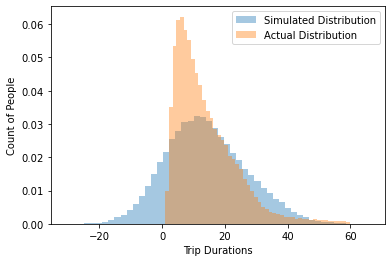

In [129]:
# Create random_state so any random operation always returns the same result.
random_state = np.random.RandomState(0)

# Generate some data using the GMM parameters we just estimated above.
num_people = all_trip_dur.shape[0]
# First let's create an array of bernouilli samples with probability of success pi_1.
dist_number = random_state.binomial(1, pi_1, size=num_people)
# Now let's create two arrays of size n that hold data from the two Gaussian distributions
# we estimated.
dist_0_trip_dur = random_state.randn(num_people) * sigma_0 + mu_0
dist_1_trip_dur = random_state.randn(num_people) * sigma_1 + mu_1
# Now use the original array of bernouilli samples to subsample the two Gaussian arrays.
generated_trip_dur = np.zeros(num_people)
generated_trip_dur[dist_number == 0] = dist_0_trip_dur[dist_number == 0]
generated_trip_dur[dist_number == 1] = dist_1_trip_dur[dist_number == 1]

# Plot the generated data.
sns.distplot(generated_trip_dur, kde=False, label="Simulated Distribution", norm_hist =True)
# Plot the real heights.
sns.distplot(all_trip_dur, kde=False, label="Actual Distribution", norm_hist = True)
# Add the legend and axis labels to the plot.
plt.xlabel("Trip Durations")
plt.ylabel("Count of People")
plt.legend()
plt.show()

###  3.4 Classifier

With the posterior distribution of subscribers and casual riders in Chicago, I buid a classifier accordingly. 
* If the posterior probability of a rider to be a subscriber is greater 0.5, then it will be classified as **subscriber(label "1")**; otherwise, it will be label as **casual rider(label "0")**.

* The performance of the classifier is given below.


In [130]:
def classifier(trip_dur):
    pos1 = 0.6970* scipy.stats.norm(8.82, 7.26).pdf(trip_dur)
    pos2 = 0.3030*scipy.stats.norm(25.83, 11.79).pdf(trip_dur)
    ratio = pos1/(pos1+pos2)
    if ratio > 0.5:
        return 1
    else:
        return 0

In [46]:
copy_chi_df = chi_df[chi_df["tripduration"] < 3600]
copy_chi_df["tripduration"] = copy_chi_df["tripduration"]/60
copy_chi_df["type_classified"] =  copy_chi_df['tripduration'].apply(lambda x: classifier(x))

<ipython-input-46-b59ac0d650cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_chi_df["tripduration"] = copy_chi_df["tripduration"]/60
<ipython-input-46-b59ac0d650cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_chi_df["type_classified"] =  copy_chi_df['tripduration'].apply(lambda x: classifier(x))


In [48]:
## accuracy
TP = sum((copy_chi_df["type_classified"] == True) & (copy_chi_df["usertype"] == "Subscriber"))
TF = sum((copy_chi_df["type_classified"] == False) & (copy_chi_df["usertype"] == "Customer"))
FP = sum((copy_chi_df["type_classified"] == True) & (copy_chi_df["usertype"] == "Customer"))
FN = sum((copy_chi_df["type_classified"] == False) & (copy_chi_df["usertype"] == "Subscriber"))
total = TP + TF + FP + FN
accuracy = (TP+TF)/total
error_rate = (FP+FN)/total
sensitivity = TP/(TP + FN)

In [49]:
print("---------Performance of Classifier in Chicago.csv--------")
print("Accuracy = {:.4f}, Error rate = {:.2f}, Sensitivity = {:.2f}".format(accuracy, error_rate,sensitivity))
print("---------------------------------------------------------")

---------Performance of Classifier in Chicago.csv--------
Accuracy = 0.8068, Error rate = 0.19, Sensitivity = 0.89
---------------------------------------------------------


### 3.5 Apply the classifier in New York & Washington DC
Assuming the scooter riders' trip durations are distributed similarly in NY and DC, leverage the model built above, and<br /> report the **Accuracy, Error rate, Sensitivity**. These statistics can also be treated the as the result of "test data" in a<br /> "train-test" Machine Learning manner.

#### New York Classifiers

ny_df = pd.read_csv("../data/bikeshare/ny.csv")

In [51]:
ny_df["tripduration"] = ny_df["tripduration"]/60
ny_df["type_classified"] = ny_df['tripduration'].apply(lambda x: classifier(x))

In [52]:
## accuracy
TP = sum((ny_df["type_classified"] == True) & (ny_df["usertype"] == "Subscriber"))
TF = sum((ny_df["type_classified"] == False) & (ny_df["usertype"] == "Customer"))
FP = sum((ny_df["type_classified"] == True) & (ny_df["usertype"] == "Customer"))
FN = sum((ny_df["type_classified"] == False) & (ny_df["usertype"] == "Subscriber"))
total = TP + TF + FP + FN
accuracy = (TP+TF)/total
error_rate = (FP+FN)/total
sensitivity = TP/(TP + FN)

In [53]:
print("---------Performance of Classifier in ny.csv--------")
print("Accuracy = {:.4f}, Error rate = {:.2f}, Sensitivity = {:.2f}".format(accuracy, error_rate,sensitivity))
print("---------------------------------------------------------")

---------Performance of Classifier in ny.csv--------
Accuracy = 0.8168, Error rate = 0.18, Sensitivity = 0.85
---------------------------------------------------------


#### Washington D.C. Classifiers

In [54]:
dc_df = pd.read_csv("../data/bikeshare/dc.csv")

In [55]:
dc_df["Duration(mininutes)"] = dc_df["Duration (ms)"]/60000
dc_df["type_classified"] = dc_df["Duration(mininutes)"].apply(lambda x: classifier(x))

In [56]:
## accuracy
TP = sum((dc_df["type_classified"] == True) & (dc_df["Member Type"] == "Registered"))
TF = sum((dc_df["type_classified"] == False) & (dc_df["Member Type"] == "Casual"))
FP = sum((dc_df["type_classified"] == True) & (dc_df["Member Type"] == "Casual"))
FN = sum((dc_df["type_classified"] == False) & (dc_df["Member Type"] == "Registered"))
total = TP + TF + FP + FN
accuracy = (TP+TF)/total
error_rate = (FP+FN)/total
sensitivity = TP/(TP + FN)

In [57]:
print("---------Performance of Classifier in dc.csv--------")
print("Accuracy = {:.4f}, Error rate = {:.2f}, Sensitivity = {:.2f}".format(accuracy, error_rate,sensitivity))
print("---------------------------------------------------------")

---------Performance of Classifier in dc.csv--------
Accuracy = 0.8235, Error rate = 0.18, Sensitivity = 0.89
---------------------------------------------------------


### 3.6 Mixtures of Bivariate Gaussians on Start-Time
Similar to previous section, it's reasonable to apply a mixture of bivariate
Gaussians using the start-times of the data, <br />which will serves as another important classifier distinguishing subscribers and casual riders. 

In [131]:
## For optional use df
chi_df['starttime_pd'] = pd.to_datetime(chi_df['starttime'])
chi_df['min_postMid'] = chi_df['starttime_pd'].dt.hour * 60 + chi_df['starttime_pd'].dt.minute

In [132]:
# Save all min_postMid in a numpy array.
all_pMid = chi_df[chi_df["tripduration"] < 3600]["min_postMid"]  #.to_numpy()

# Split the tripduration by usertype.
is_subc = (chi_df["usertype"] == "Subscriber")
subc_pMid = all_pMid[is_subc]
cas_pMid = all_pMid[is_subc == False]

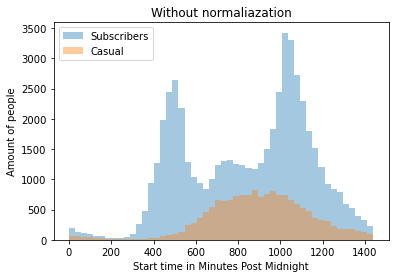

In [133]:
# Plot a histogram of Subscribers and casual riders' start time in minutes post midnight.
sns.distplot(subc_pMid, kde=False, label = "Subscribers")
sns.distplot(cas_pMid, kde=False, label = "Casual")
plt.xlabel("Start time in Minutes Post Midnight")
plt.ylabel("Amount of people")
plt.title("Without normaliazation")
plt.legend()
plt.show()

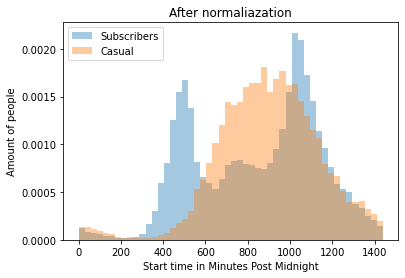

In [134]:
# Plot a histogram of Subscribers and casual riders' start time in minutes post midnight.
sns.distplot(subc_pMid, kde=False, label = "Subscribers",norm_hist = True)
sns.distplot(cas_pMid, kde=False, label = "Casual", norm_hist = True)
plt.xlabel("Start time in Minutes Post Midnight")
plt.ylabel("Amount of people")
plt.title("After normaliazation")
plt.legend()
plt.show()

In [135]:
# Find the mean of subscriber trip durations and the standard deviation of subscriber trip durations.
mu_subc = statistics.mean(subc_pMid)
sigma_subc = statistics.stdev(subc_pMid)

# Find the mean of casual trip durations and the standard deviation of casual trip durations.
mu_cas = statistics.mean(cas_pMid)
sigma_cas = statistics.stdev(cas_pMid)  

# Find the number of subscribers and casuals.
num_subc = subc_pMid.shape[0]
num_cas = cas_pMid.shape[0]
num_people = all_pMid.shape[0]
pi_subc = num_subc/(num_people)     
pi_cas = num_cas/num_people     

# Print all the statistics.
print("---Subscriber Statistics---")
print("pi_subc ={:.4f}, mu_subc = {:.2f}, sigma_subc = {:.2f},".format(pi_subc, mu_subc, sigma_subc))
print("---Casual Rider Statistics---")
print("pi_cas ={:.4f}, mu_subc = {:.2f}, sigma_cas = {:.2f}".format(pi_cas, mu_cas, sigma_cas))

---Subscriber Statistics---
pi_subc =0.7763, mu_subc = 843.33, sigma_subc = 291.74,
---Casual Rider Statistics---
pi_cas =0.2237, mu_subc = 897.11, sigma_cas = 238.78


**Interpretation** Looking at the graphs below(Without normalization/After normalization), we found the distribution of<br /> start time of subscribers and casual riders are significantly different. The distribution of subscriber has two peaks at <br />around 8 am and 5 pm; whereas the distribution of casual riders is approximately a bell shape centering at around <br/>12 pm. 

I also calculated the statistics of both subscriber group and casual group, which give sufficicent evidence the two <br/>types of user distributed differently in their start time, and it's reasonable to run a mix Gaussian model on this dataset.

### 3.6.1 Exploration of start-time

* Now use the Expectation-Maximization (E-M) Algorithm to learn a mixture of two bivariate Gaussians that describes the distribution trip-durations of length less than
one hour and start-times in the chicago.csv dataset. 
* The start-times are in the form of minutes-past-midnight.

In [136]:
# Find the mean and the standard deviation of trip durations.
mu_a = statistics.mean(all_pMid)
sigma_a = statistics.stdev(all_pMid)

# Print the statistics across all trip durations.
print("---All Statistics---")
print("mu_a = {:.2f}, sigma_a={:.2f}".format(mu_a, sigma_a))

---All Statistics---
mu_a = 855.36, sigma_a=281.65


* Like previous, a simulation without Mix-Gaussian is added for comparison purpose.

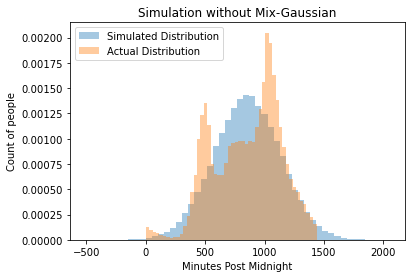

In [137]:
# Create random_state so any random operation always returns the same result.
random_state = np.random.RandomState(0)

# Generate some normally distributed random data with
# mean mu_a and standard deviation sigma_a.
num_people = all_pMid.shape[0]
generated_pMid = random_state.randn(num_people) * sigma_a + mu_a

# Plot the generated data.
sns.distplot(generated_pMid, kde=False, label="Simulated Distribution",norm_hist =True)
# Plot the real trip durations.
sns.distplot(all_pMid, kde=False, label="Actual Distribution",norm_hist =True)
# Add the legend and axis labels to the plot.
plt.xlabel("Minutes Post Midnight")
plt.ylabel("Count of people")
plt.legend()
plt.title("Simulation without Mix-Gaussian")
plt.show()

### 3.6.2 E-M Algorithm for start-time

Similar to the previous cases, we applied the E-M algorithm and got the fitted mix Gaussian distribution of start time. <br />The results don't change drastically depending on the initialization. The fitted Gaussian distribution is given below. 

subscribers: $\hat\pi_{0} = 0.4360,  \hat\mu_{0} = 583.21,  \hat\sigma_{subc} = 291.74$   

casual riders: $\hat\pi_{1} = 0.5640, \hat\mu_{1} = 1065.76, \hat\sigma_{cas}= 238.78$

* These statistics implying the casual riders tend to have a later start time than the   
subscribers, and the number of casual riders is slightly more than the subscribers. 

* However, this estimate is pretty far from the actual distribution, since the distribution   
of subscribers are actually not a normal distribution. The simulated posterior distribution   
is plotted versus the actual distribution, as shown in the graph below.

#### -------initial guess--------
$\pi_{0}= 0.5$,   $\mu_{0}= 800$,   $\sigma_{0} = 291.74$  
$\pi_{1} = 0.5$,  $\mu_{1}= 900$,   $\sigma_{1} = 238.78$          

In [138]:
sigma_0 = 291.74
sigma_1 = 238.78
# Fill in the parameters below with the values specified in the above cell.
pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data = all_pMid,
                                                                        pi_0= 0.5,
                                                                        mu_0= 800,
                                                                        pi_1= 0.5,
                                                                        mu_1= 900,
                                                                        num_steps=100)
# Print the estimated parameters for both distributions.
print("---Distribution 0 Estimated Parameters---")
print("pi_0 = {:.4f}, mu_0 = {:.2f}, sigma_subc = {:.2f}".format(pi_0, mu_0, sigma_0))
print("---Distribution 1 Estimated Parameters---")
print("pi_1 = {:.4f}, mu_1 = {:.2f}, sigma_cas = {:.2f}".format(pi_1, mu_1, sigma_1))

---Distribution 0 Estimated Parameters---
pi_0 = 0.4360, mu_0 = 583.21, sigma_subc = 291.74
---Distribution 1 Estimated Parameters---
pi_1 = 0.5640, mu_1 = 1065.76, sigma_cas = 238.78


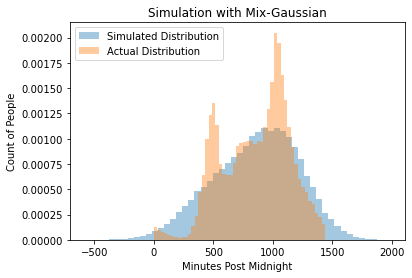

In [139]:
# Create random_state so any random operation always returns the same result.
random_state = np.random.RandomState(0)

# Generate some data using the GMM parameters we just estimated above.
num_people = all_trip_dur.shape[0]
# First let's create an array of bernouilli samples with probability of success pi_1.
dist_number = random_state.binomial(1, pi_1, size=num_people)
# Now let's create two arrays of size n that hold data from the two Gaussian distributions
# we estimated.
dist_0_pMid = random_state.randn(num_people) * sigma_0 + mu_0
dist_1_pMid = random_state.randn(num_people) * sigma_1 + mu_1
# Now use the original array of bernouilli samples to subsample the two Gaussian arrays.
generated_pMid = np.zeros(num_people)
generated_pMid[dist_number == 0] = dist_0_pMid[dist_number == 0]
generated_pMid[dist_number == 1] = dist_1_pMid[dist_number == 1]

# Plot the generated data.
sns.distplot(generated_pMid, kde=False, label="Simulated Distribution", norm_hist = True)
# Plot the real heights.
sns.distplot(all_pMid, kde=False, label="Actual Distribution", norm_hist = True)
# Add the legend and axis labels to the plot.
plt.xlabel("Minutes Post Midnight")
plt.ylabel("Count of People")
plt.legend()
plt.title("Simulation with Mix-Gaussian")
plt.show()

* To get a better **mixture bivariate Gaussian model**, we applied the method in **sklearn package**, which generates<br /> the Mixture Gaussian model desired for this question.

In [158]:
### enumerate all observations into a bivariante form: [min_postMidnight, trip_duration]
obs = np.column_stack([all_pMid, all_trip_dur])

### Obtain the model
g = mixture.GaussianMixture(n_components=2)

### fit the model
g.fit(obs)

GaussianMixture(n_components=2)

In [159]:
### get the estimated means
print("Estimated Mean:", g.means_)
### get the estimated covariance matrix
print("covariance matrix:", g.covariances_)
### get the estimated weights
print("weights:", g.weights_)
## Store the means and standard deviations
mu = g.means_
Sigma = np.sqrt(g.covariances_[1])

Estimated Mean: [[929.28362184  21.05514485]
 [799.24628259   8.59721287]]
covariance matrix: [[[ 5.89668781e+04 -3.98104389e+02]
  [-3.98104389e+02  1.09268849e+02]]

 [[ 8.74834908e+04 -7.37808474e+01]
  [-7.37808474e+01  1.69935319e+01]]]
weights: [0.43149744 0.56850256]


<ipython-input-159-9232c1047faf>:9: RuntimeWarning: invalid value encountered in sqrt
  Sigma = np.sqrt(g.covariances_[1])


### 3.6.3 Mixture Classifiers

With the mixture bivariate Gaussian Model, we compute the posterior probability, and see if a rider's combination of <br />"starttime" and "tripduration" more likely to be a subscriber or a casual rider.

Looking the performance below, we found the performance is actually worse than the one used only the trip-durations. <br />Since "Start time" for subscriber is NOT normally distributed, and actually it has two peaks, more of a gamma distribution,<br/> so our assumption that the trip durations and start times of subscriber and casual rider are normally distributed is not strictly <br/>correct. But the summary data of the model still performs at an ok level. The results displayed below:

In [160]:
def get_classifier(info):
    pos1 = g.predict_proba([[info[0], info[1]]])[0][0]
    if pos1 > 0.5:
        return 0
    else:
        return 1

In [173]:
copy_chi_df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,posterior_prob_sub,starttime_pd,min_postMid,mix_biv_class
0,9080545,3/31/2016 23:30,3/31/2016 23:46,2295,926,156,Clark St & Wellington Ave,166,Ashland Ave & Wrightwood Ave,Subscriber,Male,1990.0,0.784457,2016-03-31 23:30:00,1410,0
1,9080521,3/31/2016 22:59,3/31/2016 23:02,3439,198,259,California Ave & Francis Pl,276,California Ave & North Ave,Subscriber,Male,1974.0,0.945562,2016-03-31 22:59:00,1379,0
2,9080479,3/31/2016 22:24,3/31/2016 22:26,4337,124,344,Ravenswood Ave & Lawrence Ave,242,Damen Ave & Leland Ave,Subscriber,Female,1992.0,0.948656,2016-03-31 22:24:00,1344,0
3,9080475,3/31/2016 22:22,3/31/2016 22:41,3760,1181,318,Southport Ave & Irving Park Rd,458,Broadway & Thorndale Ave,Subscriber,Female,1979.0,0.582812,2016-03-31 22:22:00,1342,0
4,9080443,3/31/2016 22:08,3/31/2016 22:19,1270,656,345,Lake Park Ave & 56th St,426,Ellis Ave & 60th St,Subscriber,Female,1997.0,0.888328,2016-03-31 22:08:00,1328,0


In [175]:
copy_chi_df = pd.read_csv("../data/bikeshare/chicago.csv")
copy_chi_df["tripduration"] = copy_chi_df["tripduration"]/60
copy_chi_df['starttime_pd'] = pd.to_datetime(copy_chi_df['starttime'])
copy_chi_df['min_postMid'] = copy_chi_df['starttime_pd'].dt.hour * 60 + copy_chi_df['starttime_pd'].dt.minute


In [176]:
mix_classi = []
for i in range(len(copy_chi_df)):
    mix_classi.append(get_classifier(np.column_stack([copy_chi_df["min_postMid"], copy_chi_df["tripduration"]])[i]))
    

In [177]:
copy_chi_df["mix_biv_class"] =  mix_classi

In [178]:
## accuracy
TP = sum((copy_chi_df["mix_biv_class"] == True) & (copy_chi_df["usertype"] == "Subscriber"))
TF = sum((copy_chi_df["mix_biv_class"] == False) & (copy_chi_df["usertype"] == "Customer"))
FP = sum((copy_chi_df["mix_biv_class"] == True) & (copy_chi_df["usertype"] == "Customer"))
FN = sum((copy_chi_df["mix_biv_class"] == False) & (copy_chi_df["usertype"] == "Subscriber"))
total = TP + TF + FP + FN
accuracy = (TP+TF)/total
error_rate = (FP+FN)/total
sensitivity = TP/(TP + FN)

In [179]:
print("---------Performance of Mixture Classifier in Chicago.csv--------")
print("Accuracy = {:.4f}, Error rate = {:.2f}, Sensitivity = {:.2f}".format(accuracy, error_rate,sensitivity))
print("---------------------------------------------------------")

---------Performance of Mixture Classifier in Chicago.csv--------
Accuracy = 0.7490, Error rate = 0.25, Sensitivity = 0.75
---------------------------------------------------------


### 3.6.7 Classifiers on NY and DC

**NY**

In [167]:
## do NY's classification
ny_df = pd.read_csv("../data/bikeshare/ny.csv")
ny_df["tripduration"] = ny_df["tripduration"]/60
ny_df['starttime_pd'] = pd.to_datetime(ny_df['starttime'])
ny_df['min_postMid'] = ny_df['starttime_pd'].dt.hour * 60 + ny_df['starttime_pd'].dt.minute
ny_df = ny_df.loc[~ny_df['tripduration'].isnull()]
ny_df = ny_df.loc[~ny_df['min_postMid'].isnull()]

In [168]:
# Uncomment the codes below when running
mix_classi_ny = []
for i in range(len(ny_df)):
    mix_classi_ny.append(get_classifier(np.column_stack([ny_df["min_postMid"], ny_df["tripduration"]])[i]))
ny_df["mix_biv_class"] =  mix_classi_ny

In [169]:
## Accuracies
TP = sum((ny_df["mix_biv_class"] == True) & (ny_df["usertype"] == "Subscriber"))
TF = sum((ny_df["mix_biv_class"] == False) & (ny_df["usertype"] == "Customer"))
FP = sum((ny_df["mix_biv_class"] == True) & (ny_df["usertype"] == "Customer"))
FN = sum((ny_df["mix_biv_class"] == False) & (ny_df["usertype"] == "Subscriber"))
total = TP + TF + FP + FN
accuracy = (TP+TF)/total
error_rate = (FP+FN)/total
sensitivity = TP/(TP + FN)
print("---------Performance of Mix Classifier in ny.csv--------")
print("Accuracy = {:.4f}, Error rate = {:.2f}, Sensitivity = {:.2f}".format(accuracy, error_rate,sensitivity))
print("---------------------------------------------------------")

---------Performance of Mix Classifier in ny.csv--------
Accuracy = 0.7270, Error rate = 0.27, Sensitivity = 0.73
---------------------------------------------------------


**DC**

In [170]:
## do DC's classification
dc_df = pd.read_csv("../data/bikeshare/dc.csv")
dc_df["Duration(mininutes)"] = dc_df["Duration (ms)"]/60000
dc_df['starttime_pd'] = pd.to_datetime(dc_df['Start date'])
dc_df['min_postMid'] = dc_df['starttime_pd'].dt.hour * 60 + dc_df['starttime_pd'].dt.minute

In [171]:
# Uncomment the codes below when running
mix_classi_dc = []
for i in range(len(dc_df)):
    mix_classi_dc.append(get_classifier(np.column_stack([dc_df["min_postMid"], dc_df["Duration(mininutes)"]])[i]))
dc_df["mix_biv_class"] =  mix_classi_dc

In [172]:
## accuracy
TP = sum((dc_df["mix_biv_class"] == True) & (dc_df["Member Type"] == "Registered"))
TF = sum((dc_df["mix_biv_class"] == False) & (dc_df["Member Type"] == "Casual"))
FP = sum((dc_df["mix_biv_class"] == True) & (dc_df["Member Type"] == "Casual"))
FN = sum((dc_df["mix_biv_class"] == False) & (dc_df["Member Type"] == "Registered"))
total = TP + TF + FP + FN
accuracy = (TP+TF)/total
error_rate = (FP+FN)/total
sensitivity = TP/(TP + FN)
print("---------Performance of Mix Classifier in dc.csv--------")
print("Accuracy = {:.4f}, Error rate = {:.2f}, Sensitivity = {:.2f}".format(accuracy, error_rate,sensitivity))
print("---------------------------------------------------------")

---------Performance of Mix Classifier in dc.csv--------
Accuracy = 0.7505, Error rate = 0.25, Sensitivity = 0.75
---------------------------------------------------------
